In [6]:
from missing_bids import auction_data, analytics, environments
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rebidding as rb

sns.set_style('white')
%matplotlib inline

In [7]:
def check_ic(dev, dev_demand, eq_demand, cost):
    return dev_demand * ((1 + dev) - cost)  < eq_demand * (1 - cost)

## auction analysis packages
- `auction_data` provides tools to access, compute statistics of interest, and manipulate procurement auction data
- `analytics` provides tools to setup and solve a variety of safe tests as described in 

    ''Data-Driven Regulation: Theory and Application to Missing Bids'' (Chassang, Kawai, Nakabayashi and Ortner)
- `environments` is a module that helps specify constraints on, as well as generate, economic environments

## `auction_data`

First, we'll use `auction_data` to plot the distribution of winning margins, as well as the aggregate demand for auctions in the Tsuchiura dataset.

In [8]:
tsuchiura_data = auction_data.AuctionData('../tests/reference_data/tsuchiura_data.csv')

In [9]:
tsuchiura_data.df_bids.norm_bid.describe()

count    5876.000000
mean        0.946066
std         0.069519
min         0.099475
25%         0.949772
50%         0.974774
75%         0.984912
max         1.034483
Name: norm_bid, dtype: float64

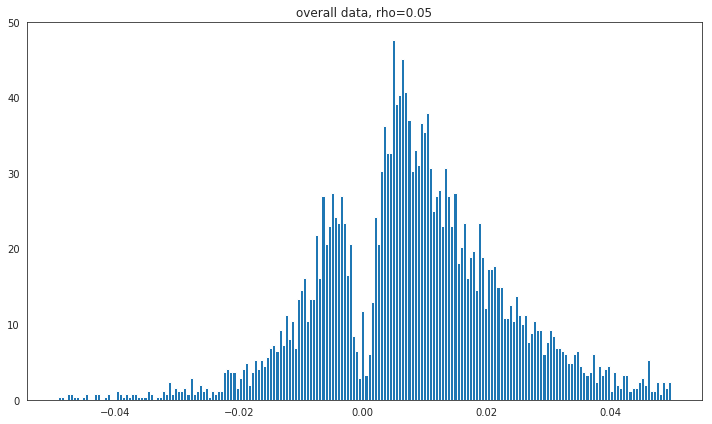

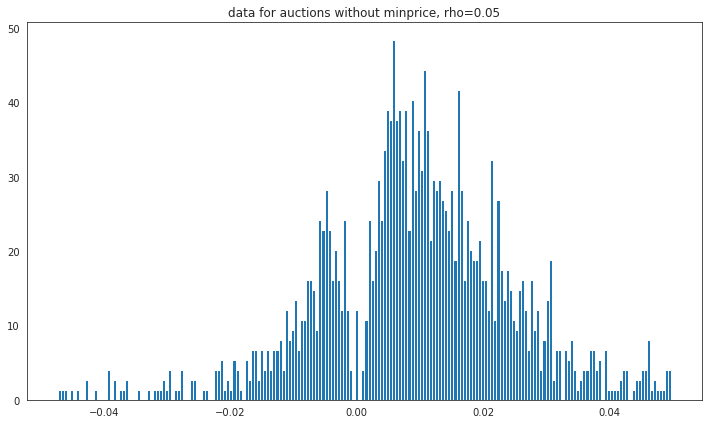

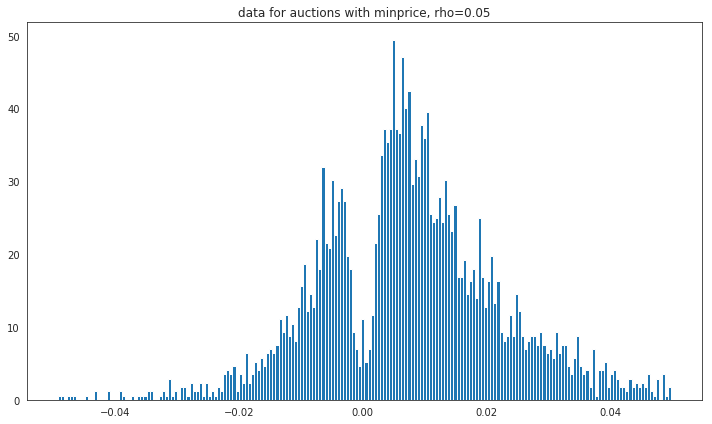

In [10]:
delta = tsuchiura_data.df_bids.norm_bid - tsuchiura_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta, 'overall data, rho={}'.format(rho))
hist_plot(delta[tsuchiura_data.data.minprice.isnull()], 
          'data for auctions without minprice, rho={}'.format(rho))
hist_plot(delta[~tsuchiura_data.data.minprice.isnull()], 
          'data for auctions with minprice, rho={}'.format(rho))

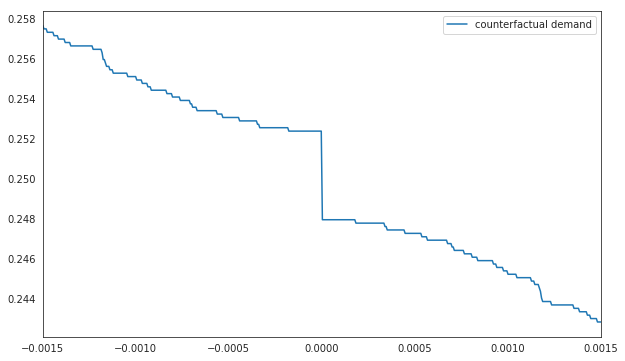

In [11]:
tsuchiura_data.demand_function(-.0015, .0015).plot(figsize = (10,6))

### `AuctionData` objects can be seeded using a selected dataframe

In [12]:
tsuchiura_before_min_price = auction_data.AuctionData(
    tsuchiura_data.df_bids.loc[tsuchiura_data.data.minprice.isnull()])

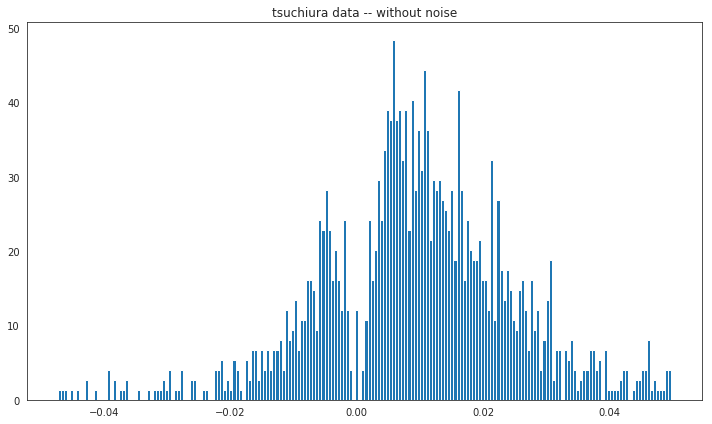

In [37]:
delta = tsuchiura_before_min_price.df_bids.norm_bid - tsuchiura_before_min_price.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta, 'tsuchiura data -- without noise')

In [20]:
tsuchiura_data.df_bids.norm_bid.std()

0.06951941876833075

In [35]:
df_noisy_bids = tsuchiura_before_min_price.df_bids.copy()
df_noisy_bids['norm_bid'] += .05 * .07 * np.random.randn(df_noisy_bids.shape[0])
tsuchiura_noisy_data = auction_data.AuctionData(df_noisy_bids) 

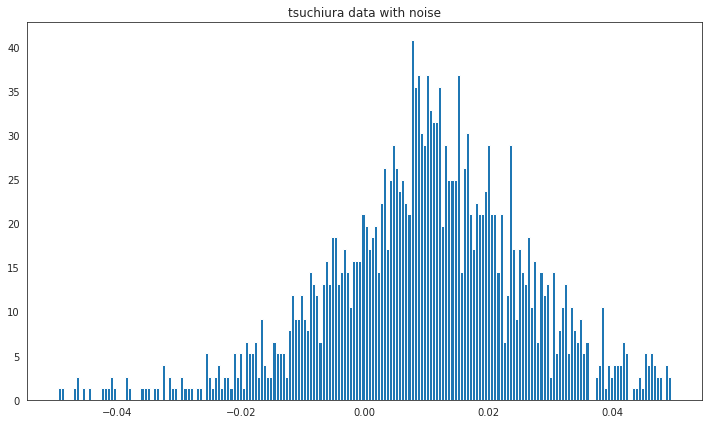

In [38]:
delta = tsuchiura_noisy_data.df_bids.norm_bid - tsuchiura_noisy_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta, 'tsuchiura data with noise'.format(rho))

### An `AuctionData` object can be created from a clean bids dataframe

In [9]:
df_bids = tsuchiura_data.df_bids.loc[tsuchiura_data.data.bidder == 'muramatsu']
auction_data_murumatsu = auction_data.AuctionData.from_clean_bids(df_bids)
auction_data_murumatsu.df_bids.equals(df_bids)

True

## `analytics`

Next, we use `analytics` to compute the minimum number of non-competitive histories, as well as the minimum normalized deviation temptation respectively corresponding to deviations $[-.015, 0, .002]$ and $[-.015, 0, .015]$

### Share of collusive auctions

#### level moment condition
We first consider the case were constraints are applied on demand levels 

#### filtering ties

In [10]:
filter_ties = auction_data.FilterTies(tolerance=.0001)
share_ties = filter_ties.get_ties(tsuchiura_before_min_price).mean()
print('share of ties in the unfiltered data {}'.format(share_ties))

filtered_data = filter_ties(tsuchiura_before_min_price)
print('share of ties in the filtered data: {}'.format(
    filter_ties.get_ties(filtered_data).mean()))

share of ties in the unfiltered data 0.010416666666666666
share of ties in the filtered data: 0.0


/home/sylvain/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


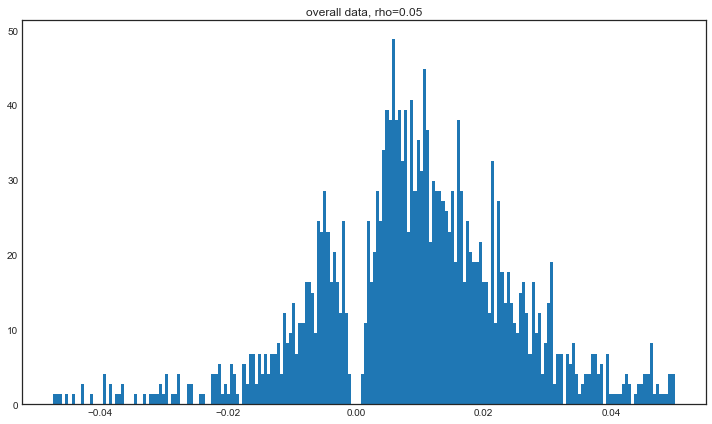

maximum gap in the data: 0.0008075237000000346


In [11]:
delta = filtered_data.df_bids.norm_bid - filtered_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta, 'overall data, rho={}'.format(rho))
print('maximum gap in the data: {}'.format(np.min(np.abs(delta))))

In [12]:
deviations = [-.02, .0, .0008] 
demands = [filtered_data.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.657617728531856, 0.21772853185595567, 0.21772853185595567]


In [13]:
constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.01), 
               environments.InformationConstraint(k=.5, sample_demands=demands)]

In [14]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=filtered_data, 
    deviations=deviations, 
    metric=analytics.IsNonCompetitive, 
    plausibility_constraints=constraints, 
    num_points=1000.0, 
    seed=0, 
    project=True, 
    filter_ties=filter_ties,
    number_iterations=50,
    confidence_level=.95,
    moment_matrix=auction_data.moment_matrix(deviations, 'level')
)

In [15]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))

solver demands: [0.65761773 0.21772853 0.21772853]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: 0.0008791982873059582


In [16]:
result = min_collusion_solver.result
print('minimum share of collusive auctions: {}'.format(result.solution))
result.argmin.head()

minimum share of collusive auctions: -3.1083901716078597e-13


,-0.02,0.0,0.0008,cost,metric,prob
0,0.554402,0.156433,0.146941,0.980985,0.0,0.171735
1,0.607385,0.195183,0.186731,0.974027,0.0,0.023450
2,0.671702,0.244871,0.237289,0.970401,0.0,0.020409
3,0.633823,0.211519,0.204734,0.970000,0.0,0.018213
4,0.598691,0.184997,0.176875,0.971360,0.0,0.016763


#### slope moment condition

In [17]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=tsuchiura_before_min_price, 
    deviations=deviations, 
    metric=analytics.IsNonCompetitive, 
    plausibility_constraints=constraints, 
    num_points=1000.0, 
    seed=0, 
    project=True, 
    filter_ties=None,
    number_iterations=50,
    confidence_level=.95,
    moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
    moment_weights=np.array([0, 0, 1])
)

In [18]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))

solver demands: [0.65899123 0.21792763 0.21546053]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: 3.6820223530317038e-06


In [19]:
result = min_collusion_solver.result
print('minimum share of collusive auctions: {}'.format(result.solution))
result.argmin.head()

minimum share of collusive auctions: 0.11632457201196703


,-0.02,0.0,0.0008,cost,metric,prob
0,0.634995,0.154807,0.149844,0.974506,0.0,8.836754e-01
1,0.694372,0.175190,0.175189,0.669837,1.0,1.163241e-01
2,0.623047,0.150945,0.150944,0.694303,1.0,1.887315e-07
3,0.657248,0.145698,0.145697,0.755808,1.0,1.804766e-07
4,0.599225,0.187814,0.187812,0.984514,1.0,2.924922e-08


### Multidimensional moment condition

In [20]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=tsuchiura_before_min_price, 
    deviations=deviations, 
    metric=analytics.IsNonCompetitive, 
    plausibility_constraints=constraints, 
    num_points=1000.0, 
    seed=0, 
    project=True, 
    filter_ties=None,
    number_iterations=50,
    confidence_level=.98,
    moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
    moment_weights=np.identity(3)
)

In [21]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))
print('joint confidence: {}'.format(min_collusion_solver.joint_confidence))

solver demands: [0.65899123 0.21792763 0.21546053]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: [[1.08504540e-03]
 [6.79633697e-04]
 [3.70456535e-06]]
joint confidence: 0.94


In [22]:
result = min_collusion_solver.result
print('minimum share of collusive auctions: {}'.format(result.solution))
result.argmin.head()

minimum share of collusive auctions: 0.1325264386528317


,-0.02,0.0,0.0008,cost,metric,prob
0,0.634995,0.154807,0.149844,0.974506,0.0,8.138635e-01
1,0.599225,0.187814,0.187812,0.984514,1.0,9.911614e-02
2,0.582037,0.167565,0.161069,0.977800,0.0,5.361002e-02
3,0.558399,0.159454,0.159336,0.673639,1.0,3.341029e-02
4,0.560378,0.152840,0.152490,0.714712,1.0,3.656669e-10


### example with rebidding

In [23]:
# this example requires some normalized bids to be greater than 1

multistage_raw_data = tsuchiura_before_min_price.raw_data.copy()
multistage_raw_data.loc[:, 'norm_bid'] = multistage_raw_data.norm_bid * 1.0

multistage_data = rb.MultistageAuctionData(multistage_raw_data)

In [24]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=multistage_data, 
    deviations=deviations, 
    metric=rb.MultistageIsNonCompetitive, 
    plausibility_constraints=constraints, 
    num_points=1000.0, 
    seed=0, 
    project=True, 
    filter_ties=None,
    number_iterations=50,
    confidence_level=.98,
    moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
    moment_weights=np.identity(3)
)

In [25]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))
print('joint confidence: {}'.format(min_collusion_solver.joint_confidence))

solver demands: [0.65899123 0.21792763 0.21546053]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: [[1.08504540e-03]
 [6.79633697e-04]
 [3.70456535e-06]]
joint confidence: 0.94


In [26]:
result = min_collusion_solver.result
print('minimum share of collusive auctions: {}'.format(result.solution))
result.argmin.head()

minimum share of collusive auctions: -1.7344569577618712e-12


,-0.02,0.0,0.0008,cost,metric,prob
0,0.616291,0.192962,0.189664,0.953913,0.0,0.517332
1,0.566590,0.153923,0.150900,0.959373,0.0,0.187976
2,0.716057,0.169260,0.165208,0.965996,0.0,0.067227
3,0.585828,0.150541,0.146992,0.954094,0.0,0.019566
4,0.708243,0.155292,0.150934,0.964429,0.0,0.011134


### Minimum deviation temptation

In [27]:
deviations = [-.02, .0, .01]
demands = [tsuchiura_before_min_price.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.6589912280701754, 0.21792763157894735, 0.09758771929824561]


In [28]:
constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.01), 
               environments.InformationConstraint(k=.5, sample_demands=demands)]

In [29]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=tsuchiura_before_min_price, 
    deviations=deviations, 
    metric=analytics.NormalizedDeviationTemptation, 
    plausibility_constraints=constraints, 
    num_points=1000.0,
    seed=0, 
    project=True, 
    number_iterations=50,
    confidence_level=.95,
    filter_ties=filter_ties,
    moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
    moment_weights=np.array([0, 0, 1])
)

In [30]:
print('solver demands: {}'.format(min_collusion_solver.demands))
print('rough tolerance T^2: {}'.format(4. / tsuchiura_before_min_price.df_bids.shape[0]))
print('bootstrapped tolerance T^2: {}'.format(min_collusion_solver.tolerance))

solver demands: [0.65761773 0.21772853 0.09861496]
rough tolerance T^2: 0.0021929824561403508
bootstrapped tolerance T^2: 0.00019343006883004206


In [31]:
result = min_collusion_solver.result
print('minimum deviation temptation: {}'.format(result.solution))
result.argmin.head()

minimum deviation temptation: 1.2028237427580355e-13


,-0.02,0.0,0.01,cost,metric,prob
0,0.557973,0.156515,0.066736,0.977067,0.0,0.029453
1,0.557620,0.155613,0.066015,0.989946,0.0,0.028416
2,0.555890,0.156585,0.062877,0.980985,0.0,0.019634
3,0.556881,0.153408,0.062079,0.984247,0.0,0.017646
4,0.558257,0.158327,0.062978,0.987349,0.0,0.015404


## Deviation temptation relative to profits

In [32]:
deviations = [-.02, .0, .01]
demands = [tsuchiura_before_min_price.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.01), 
               environments.InformationConstraint(k=.5, sample_demands=demands)]

[0.6589912280701754, 0.21792763157894735, 0.09758771929824561]


In [33]:
min_collusion_solver = analytics.MinCollusionIterativeSolver(
    data=tsuchiura_before_min_price, 
    deviations=deviations, 
    metric=analytics.DeviationTemptationOverProfits, 
    plausibility_constraints=constraints, 
    num_points=1000.0,
    seed=0, 
    project=True, 
    number_iterations=50,
    confidence_level=.95,
    filter_ties=filter_ties,
    moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
    moment_weights=np.array([0, .5, 1])
)

In [34]:
result = min_collusion_solver.result
print('minimum deviation temptation: {}'.format(result.solution))
result.argmin.head()

minimum deviation temptation: -3.249186365287359e-11


,-0.02,0.0,0.01,cost,metric,prob
0,0.557973,0.156515,0.066736,0.977067,0.0,0.020704
1,0.557620,0.155613,0.066015,0.989946,0.0,0.020524
2,0.555890,0.156585,0.062877,0.980985,0.0,0.018565
3,0.556881,0.153408,0.062079,0.984247,0.0,0.018109
4,0.558257,0.158327,0.062978,0.987349,0.0,0.016896
